In [77]:
!rm -rf *
!git config --global user.name "Akhilez"
!git config --global user.email "akhild18@yahoo.com"
!git clone https://github.com/Akhilez/ml_gallery.git
%cd ml_gallery/ml_py

Cloning into 'ml_gallery'...
remote: Enumerating objects: 605, done.
remote: Counting objects: 100% (605/605), done.
remote: Compressing objects: 100% (418/418), done.
remote: Total 2132 (delta 373), reused 368 (delta 173), pack-reused 1527
Receiving objects: 100% (2132/2132), 11.87 MiB | 19.66 MiB/s, done.
Resolving deltas: 100% (1311/1311), done.
/content/ml_gallery/ml_py/ml_gallery/ml_py/ml_gallery/ml_py


In [78]:
import os
os.environ['SECRET_KEY'] = '1234'
%mkdir -p data/mnist/numbers

In [79]:
import torch
from torch.nn.functional import relu, dropout
from collections import namedtuple
import numpy as np
from lib.mnist_aug.mnist_augmenter import DataManager, MNISTAug
import torchvision

In [80]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [151]:
#aug = MNISTAug()
#dm = DataManager()
#dm.load()
aug.max_objects = 10
aug.min_objects = 4
aug.spacing = 1
aug.scaling_mean = 1
aug.scaling_sd = 0.25
aug.overflow = 0

In [152]:
x_train, y_train = aug.get_augmented(dm.x_train, dm.y_train, 1000)
x_test, y_test = aug.get_augmented(dm.x_test, dm.y_test, 10)

In [153]:
x_train = torch.tensor(x_train.reshape(-1, 1, 112, 112)).type('torch.FloatTensor')
x_test = torch.tensor(x_test.reshape(-1, 1, 112, 112)).type('torch.FloatTensor')

[{'class': 6,
  'class_one_hot': tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]),
  'cx': 84.5,
  'cy': 63.5,
  'height': 19,
  'width': 19,
  'x1': 75,
  'x2': 94,
  'y1': 54,
  'y2': 73},
 {'class': 4,
  'class_one_hot': tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]),
  'cx': 78.5,
  'cy': 20.5,
  'height': 29,
  'width': 29,
  'x1': 64,
  'x2': 93,
  'y1': 6,
  'y2': 35},
 {'class': 0,
  'class_one_hot': tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  'cx': 56.0,
  'cy': 96.0,
  'height': 12,
  'width': 12,
  'x1': 50,
  'x2': 62,
  'y1': 90,
  'y2': 102},
 {'class': 4,
  'class_one_hot': tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]),
  'cx': 50.0,
  'cy': 45.0,
  'height': 18,
  'width': 18,
  'x1': 41,
  'x2': 59,
  'y1': 36,
  'y2': 54},
 {'class': 8,
  'class_one_hot': tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]),
  'cx': 38.5,
  'cy': 72.5,
  'height': 27,
  'width': 27,
  'x1': 25,
  'x2': 52,
  'y1': 59,
  'y2': 86},
 {'class': 4,
  'class_one_hot': tensor([0., 

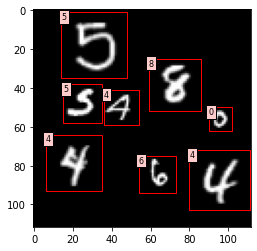

In [154]:
test_index = 3
DataManager.plot_num(x_train[test_index].reshape((112, 112)), y_train[test_index])
y_train[test_index]

In [155]:
def to_one_hot(x, num_classes=10):
  b = np.zeros((len(x), num_classes), dtype=np.float32)
  b[np.arange(len(x)), x] = 1
  return b

In [163]:
img_width = 112
n_anchors_row = 4
n_anchors = n_anchors_row ** 2
anchor_width = 28
anchor_grid_spacing = img_width / n_anchors_row

anchor_centers = []
for i in range(n_anchors_row):
  anchor_row = []
  for j in range(n_anchors_row):
    anchor_row.append([
      j * anchor_grid_spacing + anchor_grid_spacing / 2,
      i * anchor_grid_spacing + anchor_grid_spacing / 2,
    ])
  anchor_centers.append(anchor_row)
anchor_centers = torch.tensor(anchor_centers).reshape((-1, 2))

In [87]:
def get_fractional_difference(anchor, bounding_box):
  a_box = anchor
  b_box = bounding_box

  cx_d = (b_box['cx'] - a_box[0]) / img_width
  cy_d = (b_box['cy'] - a_box[1]) / img_width
  wd = (b_box['width'] - anchor_width) / img_width

  return cx_d, cy_d, wd

def get_units_from_diff(anchors, bounding_boxes):
    diffs = torch.zeros((len(anchors), 3)).to(device)
    for i in range(len(anchors)):
        diffs[i][0] = bounding_boxes[i][0] * img_width + anchors[i][0]
        diffs[i][1] = bounding_boxes[i][1] * img_width + anchors[i][1]
        diffs[i][2] = bounding_boxes[i][2] * img_width + anchor_width

    return diffs

In [88]:
def get_iou(anchor_center, bounding_box):

    half_anchor_width = anchor_width / 2
    boxA = [
        anchor_center[0]-half_anchor_width, 
        anchor_center[1]-half_anchor_width,
        anchor_center[0]+half_anchor_width,
        anchor_center[1]+half_anchor_width
    ]
    boxB = [bounding_box['x1'], bounding_box['y1'], bounding_box['x2'], bounding_box['y2']]

    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

In [89]:
def get_positive_anchors(y_batch):
    """
    1. For Each item in the batch:
    2. For each anchor box:
    - For each bounding box:
        - Find the IoU.
    - Pick bounding box with highest IoU for that anchor.
    - # TODO: Pick the anchor with the highest IoU for that bounding box.
    - If highest IoU is < 0.3, then continue 1.
    # - Create the difference units for the anchor and the bounding box as y
    - Now add the anchor box and bounding box into a map.
    """
    all_positive_pairs = []
    for batch_i in range(len(y_batch)):
        positive_pairs_batch = []
        max_iou_b = {}
        max_iou_a = {}

        # ---------- The two loops --------------

        for anchor_i in range(len(anchor_centers)):
            for bb_i in range(len(y_batch[batch_i])):

                b_box = y_batch[batch_i][bb_i]
                a_box = anchor_centers[anchor_i]

                iou = get_iou(a_box, b_box)
                default_iou = {'iou': 0, 'bb_i': -1, 'ab_i': -1}

                # --------------- Find max IoUs ------------------

                if iou > max_iou_b.get(bb_i, default_iou)['iou']:
                    max_iou_b[bb_i] = {
                        'iou': iou,
                        'bb_i': bb_i,
                        'ab_i': anchor_i
                    }

                if iou > 0.5 and iou > max_iou_a.get(anchor_i, default_iou)['iou']:
                    max_iou_a[anchor_i] = {
                        'iou': iou,
                        'bb_i': bb_i,
                        'ab_i': anchor_i
                    }

        # --------- Merge both max ious ----------------
        
        positive_pairs = [max_iou_b[index] for index in list(max_iou_b.keys())]
        for index in list(max_iou_a.keys()):
            if max_iou_a[index] not in positive_pairs:
                positive_pairs.append(max_iou_a[index])
        all_positive_pairs.append(positive_pairs)

    return all_positive_pairs

In [90]:
positives = get_positive_anchors(y_test[:2])
for positive in positives:
  print(len(positive))
n_anchors

2
3


16

In [91]:
def get_y_d(y):
  """
  Find all the positive anchor pairs.
  for each of y:
    for each pair in yi:
      find fractional difference in anchor and bounding box.
      append the fractional difference to the pair.
  """
  y_d = []
  positive_pairs = get_positive_anchors(y)
  for yi in range(len(y)):
    diffs = []
    for pair_i in range(len(y[yi])):
      pair = positive_pairs[yi][pair_i]
      anchor = anchor_centers[pair['ab_i']]
      bounding_box = y[yi][pair['bb_i']]
      cx_d, cy_d, wd = get_fractional_difference(anchor, bounding_box)
      diffs.append((cx_d, cy_d, wd, pair['ab_i'], pair['bb_i']))
    y_d.append(torch.tensor(diffs))
  return y_d

In [157]:
y_train_d = get_y_d(y_train)
y_test_d = get_y_d(y_test)

In [196]:
is_training = True
drop_p = 0.3


class BoxPredictor(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.linear1 = torch.nn.Linear(1024, 512)
    self.linear2 = torch.nn.Linear(512, 3 * n_anchors)

  def forward(self, x):
    x = dropout(relu(self.linear1(x)), drop_p, is_training)
    x = torch.tanh(self.linear2(x))
    return x.reshape((-1, n_anchors, 3))


class ConfidencePredictor(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.linear1 = torch.nn.Linear(1024, 512)
    self.linear2 = torch.nn.Linear(512, n_anchors)

  def forward(self, x):
    x = dropout(torch.relu(self.linear1(x)), drop_p, is_training)
    x = torch.sigmoid(self.linear2(x))
    return x


class DetectorV1 (torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 10, 3, padding=1)
        self.conv2 = torch.nn.Conv2d(10, 20, 3, stride=2, padding=1)
        self.conv3 = torch.nn.Conv2d(20, 40, 3, stride=2)
        self.conv4 = torch.nn.Conv2d(40, 80, 3, stride=2, padding=1)
        self.conv5 = torch.nn.Conv2d(80, 160, 3, stride=2)
        self.linear1 = torch.nn.Linear(5760, 1024)
        self.box_predictor = BoxPredictor()
        self.confidence_predictor = ConfidencePredictor()

    def forward(self, x):
        x = relu(self.conv1(x))
        x = relu(self.conv2(x))
        x = relu(self.conv3(x))
        x = relu(self.conv4(x))
        x = relu(self.conv5(x))
        x = torch.flatten(x, 1)
        x = dropout(relu(self.linear1(x)), drop_p, is_training)
        boxes = self.box_predictor(x)
        confidences = self.confidence_predictor(x)
        return boxes, confidences

model = DetectorV1().to(device)

In [197]:
optimizer = torch.optim.Adam(model.parameters())
# optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)

Steps:
 - get the predictions.
 - Find the anchors which have >0.1 IoU -> +ve anchors
 - Find the matching bounding box for each +ve anchor
 - All +ve anchors are high confidence, rest are low.
 - What is the loss for -ve anchors?


 - For each of the positive anchors, Find loss and add it to the total loss.
 - Find loss of the confidences.
 - 


In [ ]:
epochs = 50
batch_size = 16
is_training = True

for epoch in range(epochs):
    
    for i in range(0, len(x_train), batch_size):
        start_index = i
        end_index = i+batch_size
        
        x_batch = x_train[start_index:end_index].to(device)
        y_batch = y_train_d[start_index:end_index]
        
        optimizer.zero_grad()

        y_hat_boxes, y_hat_confidences = model(x_batch)

        loss = 0
        for batch_i in range(len(y_batch)):  # Each image
            y_diffs = y_batch[batch_i]
            """
            1. find losses for each positive anchor
            2. Sum them all up.
            3. Create an array of n_anchors length for target confidences.
            4. Make confidences 1 for positive indices.
            5. Find losses for confidences. 
            """
            y_confidences = torch.zeros((n_anchors)).to(device)
            for anchor_i in range(len(y_batch[batch_i])):  # Each positive anchor
                box_index = int(y_batch[batch_i][anchor_i][4])
                yd_box = y_batch[batch_i][anchor_i][:3].to(device)

                anchor_index = int(y_batch[batch_i][anchor_i][3])
                yd_pred = y_hat_boxes[batch_i][anchor_index]

                loss += sum((yd_box - yd_pred) ** 2)

                y_confidences[anchor_index] = 1.0

            loss += sum((y_confidences - y_hat_confidences[batch_i]) ** 2)
        
        loss.backward()
        optimizer.step()

    print(f'Epoch: {epoch}\tloss: {float(loss)}')

Epoch: 0	loss: 23.839130401611328
Epoch: 1	loss: 16.75935173034668
Epoch: 2	loss: 9.506013870239258
Epoch: 3	loss: 9.902826309204102
Epoch: 4	loss: 7.350144863128662
Epoch: 5	loss: 5.455845355987549
Epoch: 6	loss: 5.367511749267578
Epoch: 7	loss: 4.230063438415527


- get predictions
- get all anchor indices where confidences are > 0
- Find the coordinates of the boxes.
- Do nms on those.
- plot them.

In [ ]:
with torch.no_grad():
    is_training = False
    y_hat_boxes, y_hat_confidences = model(x_test.to(device))
    for batch_i in range(len(x_test)):
        positive_indices = (y_hat_confidences[batch_i] > 0.7).nonzero().reshape((-1))

        pred_boxes = y_hat_boxes[batch_i][positive_indices]
        anchors = anchor_centers[positive_indices]
        pred_confidences = y_hat_confidences[batch_i][positive_indices]
        pred_boxes = get_units_from_diff(anchors, pred_boxes)

        pred_boxes = torch.tensor([[
            float(box[0] - box[2] / 2),
            float(box[1] - box[2] / 2),
            float(box[0] + box[2] / 2),
            float(box[1] + box[2] / 2)
         ] for box in pred_boxes]).to(device)
        
        #keep_indices = torchvision.ops.nms(pred_boxes, pred_confidences, 0.1)
        #pred_boxes = pred_boxes[keep_indices]

        DataManager.plot_num(
            x_test[batch_i].reshape((img_width, img_width)), 
            [{'x1': box[0], 'y1': box[1], 'x2': box[2], 'y2': box[3]} for box in pred_boxes] # + y_test[batch_i]
        )
